# Chapter 2: Progeamming Probabilistically - PyMC

In [1]:
#%matplotlib inline
import pymc as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from arviz import plot_trace
import arviz as az
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)

# Probabilistic programming

Bayesian statistics is conceptually very simple:   
we have some data that is fixed, in the sense that we cannot change what we have measured,   
and we have parameters whose values are of interest to us and hence we explore their plausible values.  

All the uncertainties we have are modeled using probabilities.   
In other statistical paradigms, there are different types of unknown quantities;   
in the Bayesian framework everything that is unknown is treated the same.   
If we do not know a quantity we assign a probability distribution to it. 

Then, Bayes' theorem is used   
to transform the prior probability distribution $p(θ)$  (what we know about a given problem before observing the data),   
into a posterior distribution $p(θ|D)$ (what we know after observing data). 

In other words, Bayesian statistics is a form of learning.

The possibility of automating the inference part has led to the development of
**probabilistic programming languages (PPL) that allow for a clear separation
between model creation and inference.**  

In the PPL framework, users specify a
full probabilistic model by writing a few lines of code and then inference follows
automatically.  
It is expected that probabilistic programming will have a major impact
on data science and other disciplines by enabling practitioners to build complex
probabilistic models in a less time-consuming and less error-prone way.

Probabilistic programming hides from the user details on how probabilities are manipulated and
how the inference is performed, allowing users to focus on model specification and
analysis of results.

### Inference engines

There are several methods to compute the posterior even when it is not possible to
solve it analytically. Some of the methods are:  
* **Non-Markovian methods:**
    * Grid computing
    * Quadratic approximation
    * Variational methods

* **Markovian methods:**
    * Metropolis-Hastings
    * Hamiltonian Monte Carlo/No U-Turn Sampler

Nowadays, Bayesian analysis is performed mainly by using Markov Chain Monte Carlo (MCMC) methods, with variational methods gaining momentum for bigger datasets.   
We do not need to really understand these methods to perform
Bayesian analysis, that's the whole point of probabilistic programming languages,
but knowing at least how they work at a conceptual level is often very useful, for
example for debugging our models.

### Grid computing

Grid computing is a brute-force approach.   
Even if you are not able to compute the
whole posterior, you may be able to compute the prior and the likelihood for a
given number of points.   
Let's assume we want to compute the posterior for a single
parameter model.   
The grid approximation is as follows:
1. Define a reasonable interval for the parameter (the prior should give
you a hint).
2. Place a grid of points (generally equidistant) on that interval.
3. For each point in the grid we multiply the likelihood and the prior.

In [2]:
def posterior_grid(grid_points=100, heads=6, tosses=9):
    """
    A grid implementation for the coin-flip problem
    """
    # define a grid
    grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform
    #prior = (grid  <= 0.4).astype(int)  # truncated
    #prior = abs(grid - 0.5)  # "M" prior

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(heads, tosses, grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

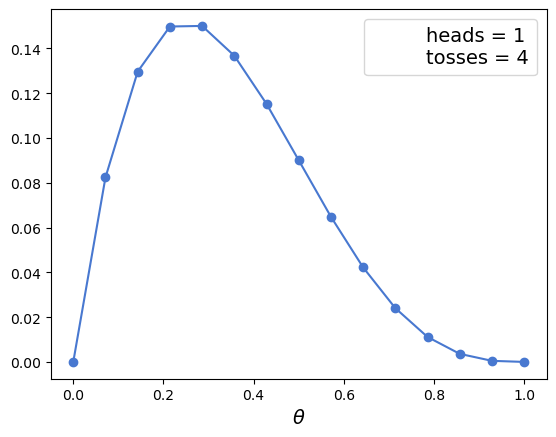

In [4]:
points = 15
h, n = 1, 4
grid, posterior = posterior_grid(points, h, n)
plt.plot(grid, posterior, 'o-')
plt.plot(0, 0, label='heads = {}\ntosses = {}'.format(h, n), alpha=0)
plt.xlabel(r'$\theta$', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.savefig('B04958_02_01.png', dpi=300);

### Quadratic method

The quadratic approximation, also known as the Laplace method or the normal
approximation, consists of approximating the posterior with a Gaussian distribution.  
This method often works because in general the region close to the mode of the
posterior distribution is more or less normal, and in fact in many cases is actually a
Gaussian distribution.   
This method consists of two steps.   
First, find the mode of the posterior distribution.   
This can be done using optimization methods; that is, methods
to find the maximum or minimum of a function, and there are many off-the-shelf
methods for this purpose.  
This will be the mean of the approximating Gaussian.
Then we can estimate the curvature of the function near the mode.  
Based on this curvature, the standard deviation of the approximating Gaussian can be computed. 

### Variational methods

Most of modern Bayesian statistics is done using Markovian methods (see the next
section), but for some problems those methods can be too slow and they do not
necessarily parallelize well.  
The naive approach is to simply run n chains in parallel
and then combine the results, but for many problems this is not a really good
solution.   
Finding effective ways of parallelizing them is an active research area.  
Variational methods could be a better choice for large datasets (think big data)
and/or for likelihoods that are too expensive to compute.   
In addition, these
methods are useful for quick approximations to the posterior and as starting points
for MCMC methods.  

The general idea of variational methods is to approximate the posterior with a
simpler distribution; this may sound similar to the Laplace approximation, but the
similarities vanish when we check the details of the method.   
The main drawback
of variational methods is that we must come up with a specific algorithm for each
model, so it is not really a universal inference engine, but a model-specific one.  
Of course, lots of people have tried to automatize variational methods. A recently
proposed method is the automatic differentiation variational inference (ADVI)
(see http://arxiv.org/abs/1603.00788).   
ADVI is already implemented on PyMC

## MCMC
To understand what
MCMC methods are we are going to split the method into the two MC parts, the
Monte Carlo part and the Markov Chain part.

## Monte Carlo

Monte Carlo methods are a very broad family of algorithms that use random sampling to compute or simulate a given process.

Monte Carlo is a very famous casino located in the Principality of Monaco.
One of the developers of the Monte Carlo method, Stanislaw Ulam, had an uncle who used to gamble there.
The key idea Stan had was that while many problems are difficult to solve or even formulate in an exact way, they can be effectively studied by taking samples from them, or by simulating them.
In fact, the motivation was to answer questions about the probability of getting a particular hand in a solitary game.
One way to solve this problem was to follow the analytical combinatorial problem.
Another way, Stan argued, was to play several games of solitaire and just count how many of the hands we play match the particular hand we are interested in! Maybe this sounds obvious, or at least pretty reasonable; for example, you may have used re-sampling methods to solve your statistical problems.
But remember this mental experiment was performed about 70 years ago, a time when the first practical computers began to be developed.
The first application of the method was to solve a problem of nuclear physics, a problem really hard to tackle using the conventional tools at that time.
Nowadays, even personal computers are powerful enough to solve many interesting problems using the Monte Carlo approach and hence these methods are applied to a wide variety of problems in science, engineering, industry, arts, and so on.

A classic  example of using a Monte Carlo method to compute a quantity
of interest is the numerical estimation of $\pi$.   
In practice there are better methods for
this particular computation, but its pedagocial value still remains.   
We can estimate
the value of $\pi$ with the following procedure:  
1. Throw $N$ points at random into a square of side $2R$.
2. Draw a circle of radius $R$ inscribed in the square and count the number of
points that are **inside** that circle.
3. Estimate $\hat{\pi}$ as the ratio  $\frac{N×inside}{4}$  
A couple of notes: We know a point is inside a circle if the following relation is true:
$$\sqrt{x^2 + y^2} ≤ R$$

The area of the square is $(2R)^2$ and the area of the circle is ${\pi}R^2$.   
Thus we
know that the ratio of the area of the square to the area of the circle is $\frac{4}{\pi}$, and the area
of the circle and squares are proportional to the number of points inside the circle
and the total $N$ points, respectively.

Using a few lines of Python we can run this simple Monte Carlo simulation and
compute $\pi$ and also the relative error of our estimate compared to the true
value of $\pi$ :

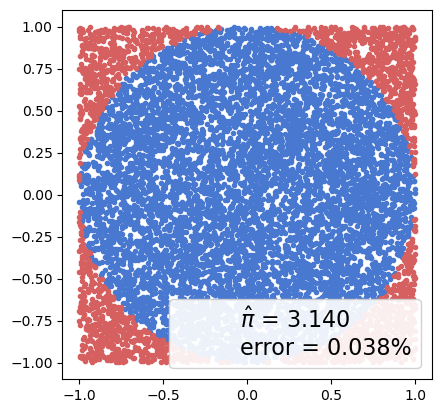

In [5]:
N = 10000

x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2)  <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi)/pi)* 100

outside = np.invert(inside)

plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label='$\hat \pi$ = {:4.3f}\nerror = {:4.3f}%'.format(pi, error), alpha=0)
plt.axis('square')
plt.legend(frameon=True, framealpha=0.9, fontsize=16);
plt.savefig('B04958_02_02.png', dpi=300)

## Markov chain
A Markov chain is a mathematical object consisting of a sequence of states and a set
of probabilities describing the transitions among those states.   
A chain is Markovian
if the probability of moving to other states depends only on the current state.  
Given such a chain, we can perform a random walk by choosing a starting point
and moving to other states following the transition probabilities.   
If we somehow
find a Markov chain with transitions proportional to the distribution we want to
sample from (the posterior distribution in Bayesian analysis), sampling becomes
just a matter of moving between states in this chain.   
So, how do we find this chain if we do not know the posterior in the first place?   
Well, there is something known as **detailed balance condition**.  
Intuitively, this condition says that we should move in
a reversible way (a reversible process is a common approximation in physics). That
is, the probability of being in state i and moving to state j should be the same as the
probability of being in state j and moving towards state i.

In summary, all this means that if we manage to create a Markov Chain satisfying
detailed balance we can sample from that chain with the guarantee that we will get
samples from the correct distribution.   
This is a truly remarkable result!   
The most
popular method that guarantees detailed balance is the Metropolis-Hasting algorithm.

# PyMC introduction 

PyMC is a Python library for probabilistic programming. PyMC provides a very simple and intuitive syntax that is easy to read and that is close to the syntax used in the statistical literature to describe probabilistic models. PyMC is written using Python. 

## Coin-flipping, the computational approach 

Let's revisit the coin-flipping problem, but this time using PyMC. The first requirement is to get our data. We will use the same synthetic data as before. Since we are generating the data we know the value of $\theta$, <span style="font-family: Courier New; font-size: 1.15em;">theta_real</span> in the following code. Of course, for a real dataset we would not have this knowledge and in fact this is what we want to estimate:

In [9]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35  # unkwon value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
data

array([1, 0, 0, 0], dtype=int64)

### Model specification 

Now that we have the data, we need to specify the model. Remember this is done by specifying the likelihood and the prior using probability distributions. As the likelihood, we will use the binomial distribution with parameter $n=1$ and $p=\theta$, and for the prior a beta with $\alpha = \beta =1$. This beta distribution is equivalent to a uniform distribution in the interval [0,1]. We can write the model using mathematical notation as follows: 

$\theta \sim Beta(\alpha=1, \beta=1)$  
$y \sim Bin(n=1, p=\theta)$  


This statistical model has an almost one-to-one translation to the PyMC syntax.   
* The first line of the code creates a container for our first model, PyMC uses the <span style="font-family: Courier New; font-size: 1.15em;">with</span> statement to indicate that everything inside the with block points to the same model.   
You can think of this as syntactic sugar to ease model specification. Imaginatively, our model is called <span style="font-family: Courier New; font-size: 1.15em;">our_first_model</span>. 
* The second line specifies the prior, and, as you can see, the syntax follows the mathematical notation closely.   
We call the random variable <span style="font-family: Courier New; font-size: 1.15em;">theta</span>.   
Please note that this name matches the first argument of the PyMC <span style="font-family: Courier New; font-size: 1.15em;">Beta</span> function; having both names the same is a good practice to avoid confusion.   
Then we will use the name of the variable to extract information from the sampled posterior.   
The variable <span style="font-family: Courier New; font-size: 1.15em;">theta</span> is a stochastic variable; we can think of this variable as the rule to generate numbers from a given distribution (a beta distribution in this case) and not actual numbers.   
* The third line specifies the likelihood following the same syntax as for the prior except that we pass the data using the <span style="font-family: Courier New; font-size: 1.15em;">observed</span> argument.   
This is the way in which we tell PyMC that this is the likelihood.   
The data can be a Python list, a NumPy array or a Pandas DataFrame.   
That's all it takes to specify our model!


In [42]:
with pm.Model() as our_first_model:
    # a priori
    theta = pm.Beta('theta', alpha=1, beta=1)
    # likelihood
    y = pm.Bernoulli('y', p=theta, observed=data)
    
    step = pm.Slice()
    trace = pm.sample(1000, step=step)    

Multiprocess sampling (4 chains in 4 jobs)
Slice: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


### Pushing the inference button 

For this problem the posterior can be computed analytically and we can also take samples form the posterior using PyMC with just a few lines.   
 
* The fourth line is used to define the sampling method.   
Here we are using Metropolis-Hastings, simply called Metropolis.  
PyMC allows us to assign different samplers to different random variables; for now we have a model with only one parameter, but later we will have more variables.   
Alternatively, we can even omit this line and PyMC will assign samplers automatically to each variable based on properties of those variables.   
For example, NUTS works only for continuous variables and hence cannot be used with a discrete one, Metropolis can deal with discrete variables, and other types of variables have specially dedicated samplers.   
In general we should let PyMC choose the sampler for us.   
* The last line performs the inference.   
The first argument is the number of samples we want, and the second and third arguments are the sampling method and the starting point. 

### Diagnosing the sampling process 

Since we are approximating the posterior with a finite number of samples, the first thing we need to do is to check if we have a reasonable approximation. There are several tests we can run, some are visual and some quantitative. These tests try to find problems with our samples but they cannot prove we have the correct distribution; they can only provide evidence that the sample seems reasonable. If we find problems with the sample, the solutions are: 
* Increase the number of samples.
* Remove a number of samples from the beginning of the trace. This is know as burn-in. MCMC methods often take some time until we start getting samples from the target distribution. The burn-in will not be necessary for an infinite sample, as it is not part of the Markovian theory. Instead, removing the first samples is an ad hoc trick to get better results given that we are getting a finite sample. Remember we should not get confused by mixing mathematical objects with the approximation of those objects. Spheres, Gaussian, Markov chains, and all the mathematical objects live only in the platonic world of the ideas, not in our imperfect but real world. 
* Re-parametrize the model, that is express the model in a different but equivalent way. 
* Transform the data. This can help a lot to get a much more efficient sampling. When transforming the data we should take care to interpret the result in the transformed space or, alternatively, revert the transformation before interpreting the results. 

### Convergence 

Generally, the first task we will perform is to check what the results look like.  The traceplot function is ideally suited to this task:

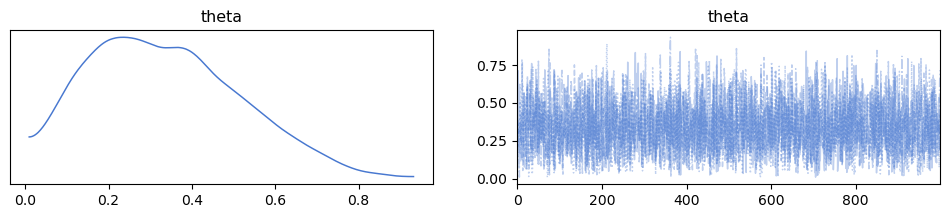

In [43]:
#burnin = 100  
#chain = trace[burnin:]
#pm.traceplot(chain, varnames=['theta'])
az.plot_trace(trace, combined=True)
plt.savefig('B04958_02_04.png', dpi=300)

We get two plots for each unobserved variable. On the left, we get a kernel density estimation (KDE) plot; this is like the smoothed version of a histogram. On the right, we get the individual sampled values at each step during the sampling. Notice that the read line is indicating the value of the variable <span style="font-family: Courier New; font-size: 1.15em;">theta_real</span>.

What do we need to look at when we see these plots?  
Often, as the number of data increases, the distribution of each parameter will tend to become Gaussian-like; this is due to the law of the large numbers.   
Of course, this is not always true.   
The plot on the right should look like white noise; we are looking for good mixing.   
We should not see any recognizable pattern, we should not see a curve going up or down, instead we want a curve meandering around a single value.   
For multimodal distributions or discrete distributions we expect the curve to not spend too much time in a value or region before moving to other regions, we want to see sampled values moving freely among these regions.   
We should also expect to see a stable auto-similar trace, that is, a trace that at different points looks more or less the same; for example, the first 10% (or so) should look similar to other portions in the trace like the last 50% or 10%.   
Once again, we do not want patterns; instead we expect something noisy.   
See the following figure for some examples of traces with good mixing (on the right) and bad mixing (on the left):


<img src="pic2\fig_2_1.png" width="700">

If the first part of the trace looks different than the others this is an indication of the need for burnin. If we see a lack of auto-similarity in other parts or we see some pattern this is an indication for more steps, or the need to use a different sampler or a different parametrization. For difficult models, we may apply a combination of all these strategies.

PyMC allows us to run a model several times in parallel and thus get a parallel chain for the same parameter. This is specified with the argument njobs in the sample function. Using traceplot, we plot all the chains for the same parameter in the same plot. Since each chain is independent of the others and each chain should be a good sample, all the chain should look similar to each other. Besides checking for convergence, these parallel chains can be used also for inference; instead of discarding the extra chains, we can combine them to increase the sample size.

In [44]:
with our_first_model:
    step = pm.Slice()
    multi_trace = pm.sample(1000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Slice: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


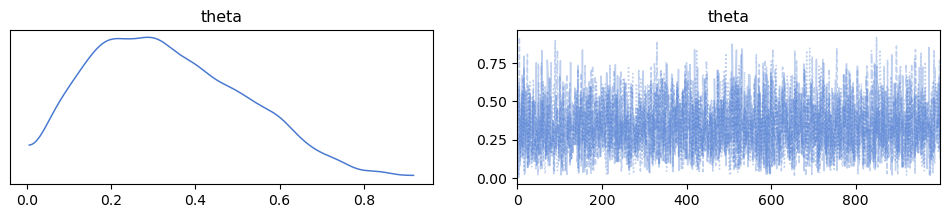

In [45]:
#burnin = 0  # no burnin
#multi_chain = multi_trace[burnin:]
#pm.traceplot(multi_chain, lines={'theta':theta_real});
az.plot_trace(multi_trace, combined=True)
plt.savefig('B04958_02_06.png', dpi=300)

A quantitative way to check for convergence is by using the Gelman-Rubin test. The idea of this test is to compare the variance between chains with the variance within chains, so of course we need more than one chain for this test to work. Ideally, we should expect a value of $\hat{R} = 1$. As an empirical rule, we will be ok with a value below 1.1; higher values are signaling a lack of convergence:


<Axes: title={'center': 'theta'}>

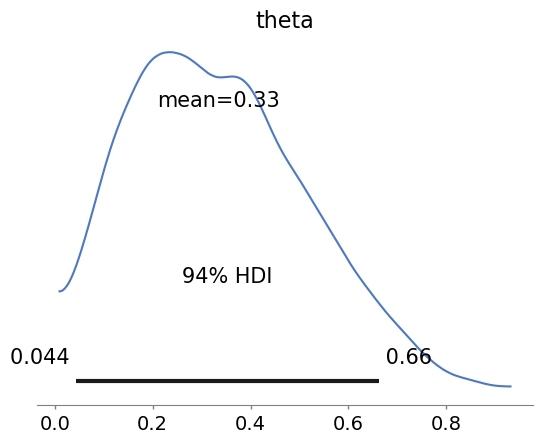

In [46]:
az.plot_posterior(trace)
#pm.plot_posterior(chain, kde_plot=True)

<Axes: title={'center': 'theta'}>

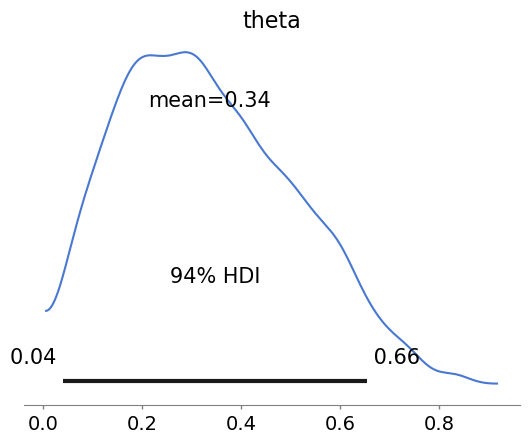

In [47]:
az.plot_posterior(multi_trace)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

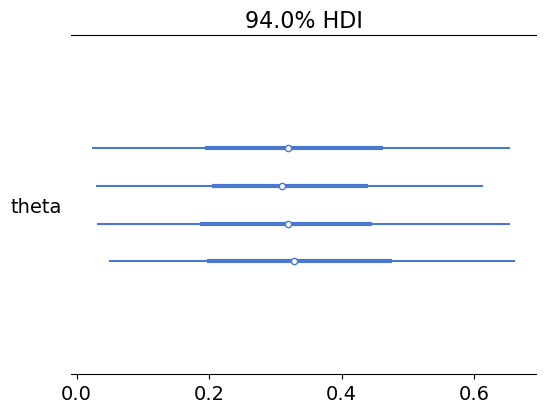

In [48]:
az.plot_forest(trace, var_names=["theta"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

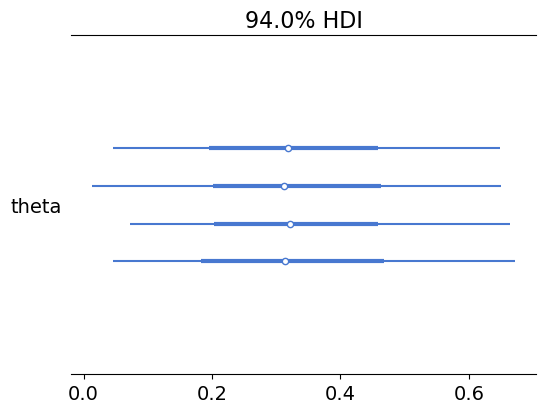

In [49]:
az.plot_forest(multi_trace, var_names=["theta"])

The function <span style="font-family: Courier New; font-size: 1.15em;">summary</span> provides a text-format summary of the posterior. We get the mean, standard deviation, and the HPD intervals:


In [50]:
az.summary(trace, round_to=2) # hpd_2.5 부터  hpd_97.5  --> 95% Credible Interval 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.33,0.18,0.04,0.66,0.0,0.0,3570.55,2524.26,1.0


In [51]:
az.summary(multi_trace, round_to=2) # hpd_2.5 부터  hpd_97.5  --> 95% Credible Interval 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.34,0.18,0.04,0.66,0.0,0.0,3674.15,2323.0,1.0
